In [1]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/mocos/numeric-model/Project.toml`


In [2]:
using CSV
using PyPlot
using SparseArrays
using JLD2
using FileIO
using LinearAlgebra
using ProgressMeter
plot_prefix = "plots/"

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Installing matplotlib via the Conda matplotlib package...
└ @ PyCall /Users/tomek/.julia/packages/PyCall/zqDXB/src/PyCall.jl:697
┌ Info: Running `conda install -y matplotlib` in root environment
└ @ Conda /Users/tomek/.julia/packages/Conda/3rPhK/src/Conda.jl:113


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/tomek/.julia/conda/3

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cycler-0.10.0              |           py37_0          14 KB
    freetype-2.9.1             |       hb4e5f40_0         555 KB
    kiwisolver-1.2.0           |   py37h04f5b5a_0          55 KB
    matplotlib-3.1.3           |           py37_0          21 KB
    matplotlib-base-3.1.3      |   py37h9aa3819_0         4.9 MB
    pyparsing-2.4.7            |             py_0          65 KB
    ------------------------------------------------------------
                                           Total:         5.6 MB

The following NEW packages will be INSTALLED:

  cycler             pkgs/main/osx-64::cycler-0.10.0-py37_0
  freetype           pkgs/main/osx-64::freetype-2.9.1-hb4e5f40_0
  kiw

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1260


######################################################################### 100,0%-=O=- #   #    #    #                                                          


┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1260


"plots/"

In [3]:
@load "data/wroclaw-population.jld2"

3-element Array{Symbol,1}:
 :household_count
 :households
 :households_all

In [4]:
function countuniquesorted(arr::AbstractArray{T,1}) where T
    d = Dict{T,Int}()
    for val in arr
        count = get(d, val, 0)
        d[val] = count + 1
    end
    
    N = length(d)
    vals = Array{T,1}()
    sizehint!(vals,N)
    counts = Array{Int,1}()
    sizehint!(counts,N)
    for (val,count) in sort(collect(d))
        push!(vals,val)
        push!(counts,count)
    end
    
    return vals,counts
end

countuniquesorted (generic function with 1 method)

In [5]:
sizes, counts = countuniquesorted(sum(households_all,dims=1) |> vec)
dist = counts./sum(counts)
num_sizes = size(dist,1)

8

In [6]:
function solve_simple(
        sizes::AbstractVector{T} where T<:Real,
        counts::AbstractVector{T} where T<:Real;
        c0::Real,
        a::Real=0,
        f1::Real=0.15,
        f2::Real=0.15,
        population::Bool=true,
        max_iters::Integer=100
    )::Real
    
    dist = counts ./ sum(counts)
    
    rho = ones(size(dist))
    new_rho = ones(size(dist))
    
    hj = sizes .* dist
    k = sizes
    k1 = ( (1-f1*a) .* k .+ f2*a )
    m = dot(sizes, dist)
    
    for iter in 1:max_iters
        r = c0 * dot(rho, hj) / m
        new_rho .= -expm1.(-r .* k1)
        if all(rho .== new_rho)
            break
        end
        tmp = rho
        rho = new_rho
        new_rho = tmp
    end

    if population
        dot(rho, hj) / m
    else
        dot(rho, dist)
    end
end

solve_simple (generic function with 1 method)

In [7]:
As = (0.4:0.4)'
Cs = 0:0.001:1
t = 2.34
C0s = t*Cs
f1 = 0.15
f2 = 0.15

@time wroclaw_simple = ((c0,a) ->solve_simple(sizes, counts, c0=c0, a=a, f1=f1, f2=f2)).(C0s, As)
;

  0.618182 seconds (2.50 M allocations: 132.044 MiB, 5.41% gc time)


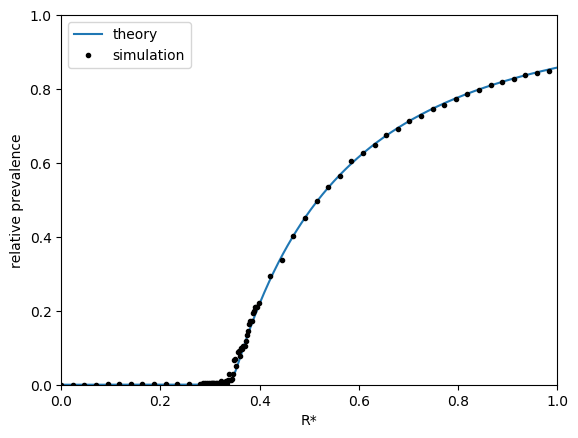

In [8]:
figure()
simulation = CSV.read("data/fig3_data.csv")[:,[:x,:y]]

#for i in 1:size(results_simple,2)
#    lines = plot(C0s, results_simple[:,i], label="a=$(As[i])")
#end

plot(C0s, wroclaw_simple, label="theory")
plot(simulation.x, simulation.y, "k.", label="simulation")

legend(loc="upper left")

xlabel("R*")
ylabel("relative prevalence")
xlim(left=0.0, right=1)
ylim(bottom=0, top=1)
#title("Dependence of relative prevalence on R*")
savefig(plot_prefix*"simple_results.png")

In [9]:
germany_df = CSV.read("data/germany_Householddistribution.csv")

,Berlin,Germany,householdsize
,Float64,Float64,Int64
1,0.536129,0.405623,1
2,0.28789,0.345139,2
3,0.0949537,0.123608,3
4,0.0578267,0.0911893,4
5,0.016577,0.0253071,5
6,0.00366581,0.00582066,6
7,0.00143683,0.00141149,7
8,0.000663316,0.000564112,8
9,0.000538212,0.000332072,9


In [10]:
poland_sizes, poland_counts = load("data/poland-population.jld2")["households_all"] |> x->sum(x, dims=1) |> vec |> countuniquesorted
@time poland_simple = ((c0,a) ->solve_simple(poland_sizes[2:end], poland_counts[2:end], c0=c0, a=a, f1=f1, f2=f2)).(C0s, As)

  0.079504 seconds (378.07 k allocations: 27.377 MiB)


1001×1 Array{Float64,2}:
 0.0
 6.333162468599756e-212
 7.989943553244647e-182
 3.2327058922530074e-164
 1.003019008109375e-151
 4.89950444970299e-142
 4.0372949697004726e-134
 1.9886338181992714e-127
 1.24596593962284e-121
 1.6161659282424032e-116
 6.052475020200241e-112
 8.296015856193096e-108
 4.958648541922298e-104
 ⋮
 0.9865555886404973
 0.9865950982665403
 0.9866344727714363
 0.9866737127129824
 0.9867128186461834
 0.9867517911232709
 0.9867906306937179
 0.9868293379042555
 0.9868679132988903
 0.9869063574189187
 0.9869446708029449
 0.9869828539868946

  0.364605 seconds (1.29 M allocations: 115.203 MiB)


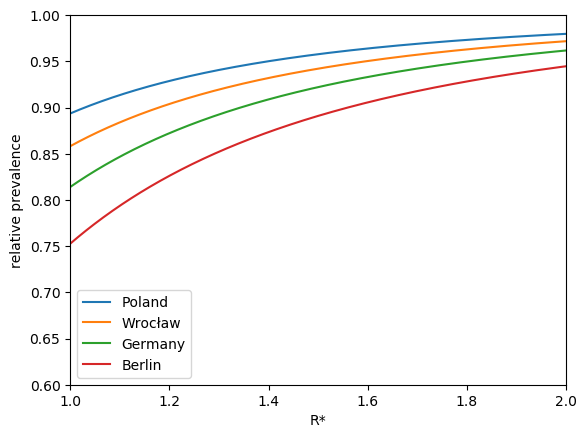

  0.122515 seconds (400.35 k allocations: 67.589 MiB)


In [11]:
@time berlin_simple = ((c0,a) ->solve_simple(germany_df.householdsize, germany_df.Berlin, c0=c0, a=a, f1=f1, f2=f2)).(C0s, As)
@time germany_simple = ((c0,a) ->solve_simple(germany_df.householdsize, germany_df.Germany, c0=c0, a=a, f1=f1, f2=f2)).(C0s, As)

plot(C0s, poland_simple, label="Poland")
plot(C0s, wroclaw_simple, label="Wrocław")
plot(C0s, germany_simple, label="Germany")
plot(C0s, berlin_simple, label="Berlin")

legend()
xlim(left=1, right=2)
ylim(bottom=0.6, top=1)
xlabel("R*")
ylabel("relative prevalence")

savefig(plot_prefix*"plots4_1-2.png")